# ENSAE - Apprentissage statistique - TP3

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Breast Cancer Wisconsin (Diagnostic) Data Set

We worked on the Breast Cancer Wisconsin Data Set we found on Kaggle.
The dataset is available here : https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

## Data description

In [5]:
df = pd.read_csv('data.csv') # Read the data
df = df.drop(['id', 'Unnamed: 32'], axis=1) # Remove useless columns
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The dataset consists of 31 variables (30 quantitatives variables and 1 binary variable) for  569 observations.

Those variables describe cells sampled from fine needle aspirate (FNA) of a breast mass (a common procedure for breast cancer detection).

Each type of measurement is described by its mean, standard deviation and maximum value among the cells of a sample.

According to the documentation of the dataset, there are ten types of measurement : 

- radius (mean of distances from center to points on the perimeter) 
- texture (standard deviation of gray-scale values) 
- perimeter 
- area 
- smoothness (local variation in radius lengths) 
- compactness ($\frac{\text{perimeter}}{\text{area}} - 1.0$) 
- concavity (severity of concave portions of the contour) 
- concave points (number of concave portions of the contour) 
- symmetry 
- fractal dimension ("coastline approximation" - 1)



357 observations correspond to benign tumors while 212 to malignant tumors : the dataset is slightly unbalanced but not too much.

In [6]:
print("Number of missing values per variable")
for column in df.columns:
    print("{} {}".format(column, df[column].isnull().sum()))

Number of missing values per variable
diagnosis 0
radius_mean 0
texture_mean 0
perimeter_mean 0
area_mean 0
smoothness_mean 0
compactness_mean 0
concavity_mean 0
concave points_mean 0
symmetry_mean 0
fractal_dimension_mean 0
radius_se 0
texture_se 0
perimeter_se 0
area_se 0
smoothness_se 0
compactness_se 0
concavity_se 0
concave points_se 0
symmetry_se 0
fractal_dimension_se 0
radius_worst 0
texture_worst 0
perimeter_worst 0
area_worst 0
smoothness_worst 0
compactness_worst 0
concavity_worst 0
concave points_worst 0
symmetry_worst 0
fractal_dimension_worst 0


There is are no missing values in the dataset.

Our goal is to predict if a sample corresponds to a benign or a malignant tumour based on the measurements of the cells.

We begin by plotting the correlations between the mean variables. 

We discard the standard deviation and maximum values, we will use them if we think we can improve the performance of prediction.

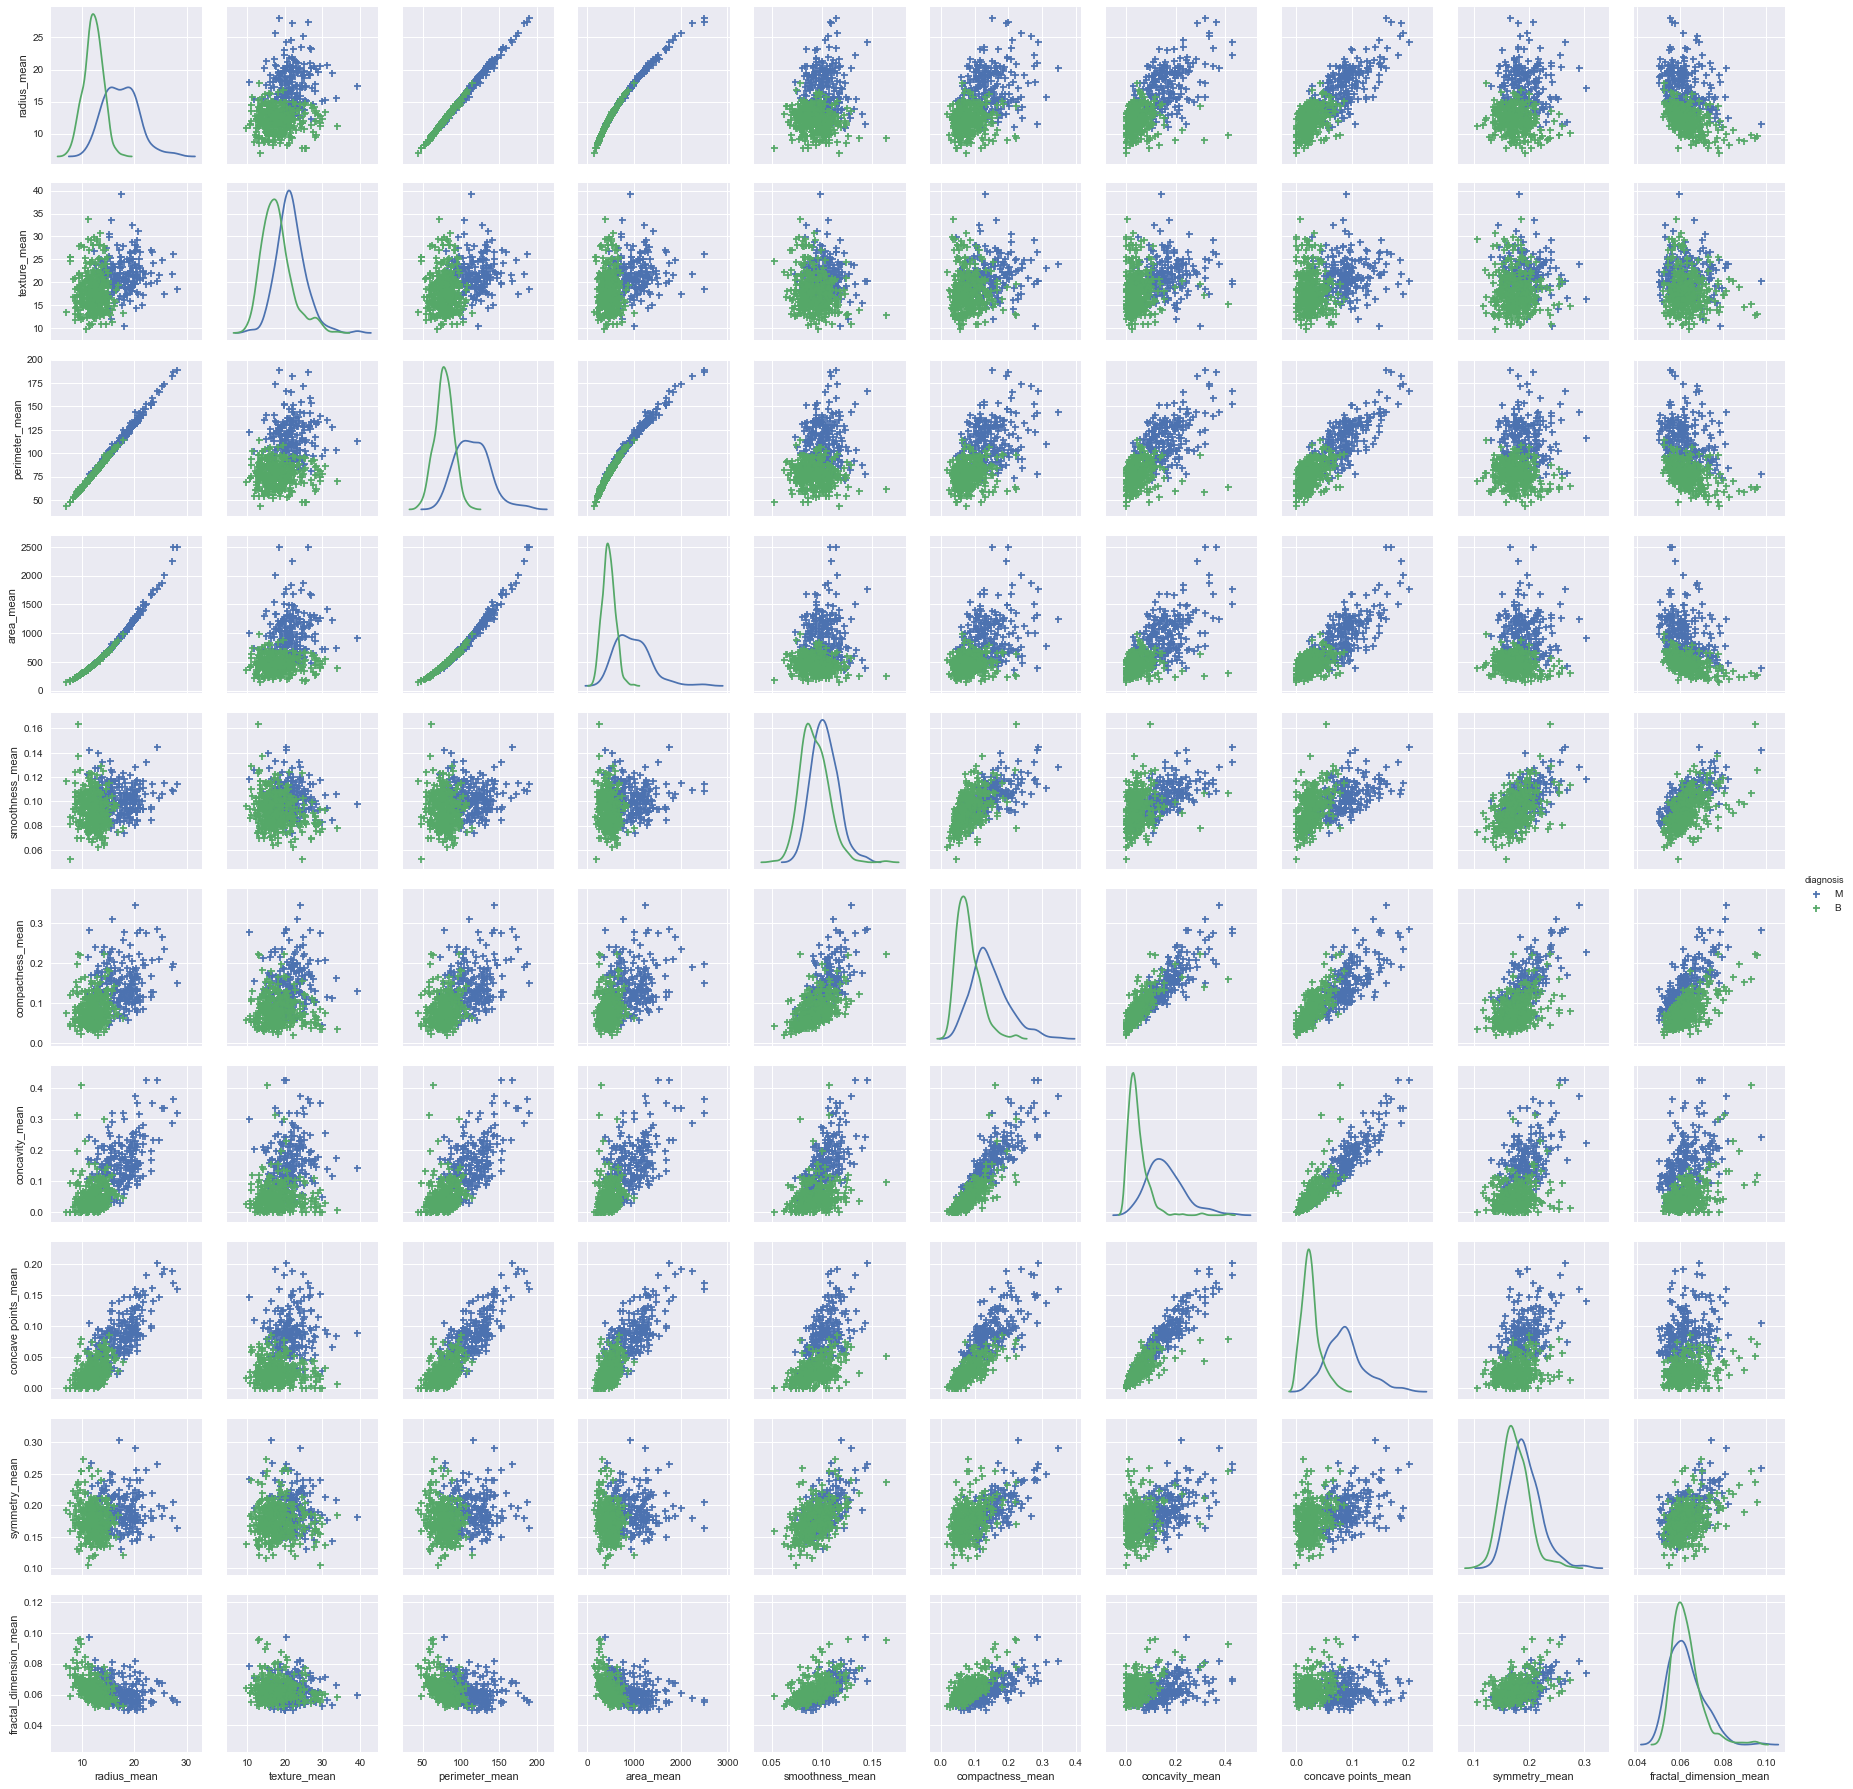

In [7]:
sns.pairplot(df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'diagnosis']], diag_kind="kde", markers="+", hue="diagnosis")

We observe that the distributions of the fractal dimension, the symmetry, the smoothness are similar for benign and malignant tumors so we discard those variables.

Also there is a really high correlation between the variables radius, area and perimeter so we just keep the first of those 3 variables.

We also notice that the two classes are almost linearly separable as visible in the next figure. Thus it should not be too difficult to obtain a high accuracy.

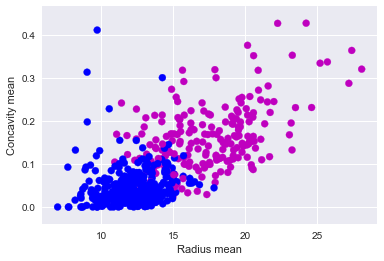

In [8]:
plt.scatter(df['radius_mean'], df['concavity_mean'], c=df['diagnosis'])
plt.xlabel('Radius mean')
plt.ylabel('Concavity mean')

In [9]:
# variables we selected for the classification task
variables = ['radius_mean', 'texture_mean', 
             'compactness_mean', 'concavity_mean',
             'concave points_mean']

## Classification

We run three types of models : a support vector machine, a random forest and a logistic regression.

We split the data into a training set and a testing set.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(df[variables], df['diagnosis'], 
                                                    test_size=0.33, random_state=42)

# binarize target
y_train = np.ravel(label_binarize(y_train, classes=['B', 'M']))
y_test = np.ravel(label_binarize(y_test, classes=['B', 'M']))

### Support Vector Machine 

We stard by training a SVM with default parameters.

In [9]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))

0.88297872340425532

The accuracy score is quite high (88%). 
We try to get an even better score with a gridsearch on the kernels (linear and rbf) and on the penalty parameter C.

In [11]:
parameters = {'kernel':('linear', 'rbf'), 'C':np.linspace(0.1, 100, 20)}
clf = GridSearchCV(svm.SVC(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([   0.1    ,    5.35789,   10.61579,   15.87368,   21.13158,
         26.38947,   31.64737,   36.90526,   42.16316,   47.42105,
         52.67895,   57.93684,   63.19474,   68.45263,   73.71053,
         78.96842,   84.22632,   89.48421,   94.74211,  100.     ]), 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
clf.best_params_

{'C': 100.0, 'kernel': 'linear'}

The best parameters correspond to $C=100$ and the best kernel between rbf and linear is the linear kernel.

In [14]:
y_pred = clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Precision score : {}".format(precision_score(y_test, y_pred)))
print("Recall score : {}".format(recall_score(y_test, y_pred)))

Accuracy score : 0.9521276595744681
Precision score : 0.953125
Recall score : 0.9104477611940298


After the grid search we obtain an accuracy of 94% which is pretty good ! The precision and recall score are also high.

This can be explained by the fact that the data is almost linearly separable so the SVM does not have any problem to generalize and learn the difference between the two classes.

### Random forest

We train a random forest classifier with the default parameters.

In [15]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [16]:
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Precision score : {}".format(precision_score(y_test, y_pred)))
print("Recall score : {}".format(recall_score(y_test, y_pred)))

Accuracy score : 0.9095744680851063
Precision score : 0.890625
Recall score : 0.8507462686567164


The performance is not as good as the performance of the SVM.

The advantage of random forest classifier is that it gives a ranking of the importance of each feature for the classification.

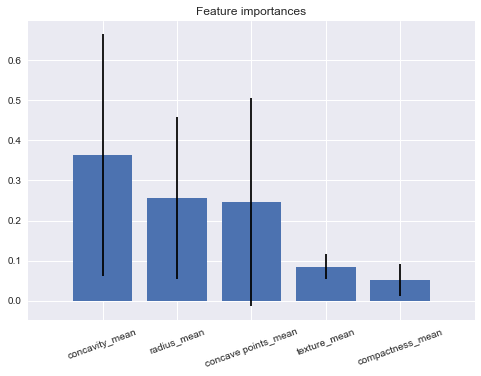

In [17]:
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

# Compute and plot importance of features
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
variable_names = [variables[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), variable_names, rotation=20)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The importance plot shows that there are mainly three important variables : the number of concave points, the concavity and the radius. 

If we wanted to reduce the number of variables, we could discard texture and compactness because there relative importance is much lower.

In [27]:
parameters = {"n_estimators" : np.linspace(10, 100, 20, dtype=int), "criterion": ["gini", "entropy"]}
clf = GridSearchCV(RandomForestClassifier(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  14,  19,  24,  28,  33,  38,  43,  47,  52,  57,  62,  66,
        71,  76,  81,  85,  90,  95, 100]), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
print("Best parameters found by gridsearch : {}".format(clf.best_params_))

Best parameters found by gridsearch : {'n_estimators': 85, 'criterion': 'entropy'}


In [28]:
y_pred = clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Precision score : {}".format(precision_score(y_test, y_pred)))
print("Recall score : {}".format(recall_score(y_test, y_pred)))

Accuracy score : 0.9361702127659575
Precision score : 0.8985507246376812
Recall score : 0.9253731343283582


The performance is close to the performance of the SVM, even if the SVM performs slightly better for the accuracy and precision score and is a little bit below for the recall score.

### Logistic regression

Finally we run a logistic regression on the data.

In [11]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [12]:
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Precision score : {}".format(precision_score(y_test, y_pred)))
print("Recall score : {}".format(recall_score(y_test, y_pred)))

Accuracy score : 0.925531914893617
Precision score : 1.0
Recall score : 0.7910447761194029


In [13]:
parameters = {"C" : np.logspace(-2, 2, 20), "penalty": ["l1", "l2"]}
clf = GridSearchCV(LogisticRegression(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.62378e-02,   2.63665e-02,   4.28133e-02,
         6.95193e-02,   1.12884e-01,   1.83298e-01,   2.97635e-01,
         4.83293e-01,   7.84760e-01,   1.27427e+00,   2.06914e+00,
         3.35982e+00,   5.45559e+00,   8.85867e+00,   1.43845e+01,
         2.33572e+01,   3.79269e+01,   6.15848e+01,   1.00000e+02]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
print("Best parameters found by gridsearch : {}".format(clf.best_params_))

Best parameters found by gridsearch : {'C': 14.384498882876629, 'penalty': 'l1'}


In [24]:
print("Coefficients of the logistic regression : \n {}".format(clf.best_estimator_.coef_))

Coefficients of the logistic regression : 
 [[  0.52439393   0.26460033   0.           1.84464722  83.36577746]]


We notice two interesting phenomena :
- the optimized logistic regression uses the $\mathcal{l}_1$ penalty, which shrinks and sparsifies the coefficients. This is what we observe in practice as the coefficient of the third variable (compactness) is set to 0.
- the results are coherent with the feature importances we obtained with the random forest classifier : compactness was considered as the least important variable.

In [14]:
y_pred = clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Precision score : {}".format(precision_score(y_test, y_pred)))
print("Recall score : {}".format(recall_score(y_test, y_pred)))

Accuracy score : 0.9521276595744681
Precision score : 0.9264705882352942
Recall score : 0.9402985074626866


The performance of the logistic regression with parameters optimized by gridsearch/cross-validation is comparable to the performance of the SVM and the random forest classifier.

# Conclusion

The dataset was really clean and we obtained really high performances for the three types of classifiers we considered. This can be explained by the fact that the data seems almost linearly separable.

For each of those classifiers, we ran a gridsearch on the parameters with cross-validation to automatically set the best parameters. This enabled us to compair fairly those classifiers as they were all performing as well they could.

The results we obtained on the classifiers are coherent : the variables implicitly selected by the random forest classifier and the logistic regression with $l_1$ penalty were the same.

Globally SVM gives the best results even if the two other classifiers are close. The random forest classifier is also interesting for the feature importance indices that we can use for feature selection. Finally the logistic regression is of interest because we can lead the same interpretation as for classical regressions. 